# Recommendation model 

* Write summary here *

In [16]:
import pandas as pd
import numpy as np
from datetime import datetime

In [17]:
# Read csv file
def read_data(path, includeDates=False):
    
    if includeDates:
        data = pd.read_csv(path) 
                          #parse_dates=['timestamp'])
    else:
        data = pd.read_csv(path)
    return data

Reading the csv files and checking out the data

In [136]:
rating_data = read_data('data/ratings.csv', True)
movie_data = read_data('data/movies.csv')
tags_data = read_data('data/tags.csv')
links_data = read_data('data/links.csv')
display(rating_data.head(5))
display(movie_data.head(5))
display(tags_data.head(5))
display(links_data.head(5))

,userId,movieId,rating,timestamp
0,1,307,3.5,1256677221
1,1,481,3.5,1256677456
2,1,1091,1.5,1256677471
3,1,1257,4.5,1256677460
4,1,1449,4.5,1256677264


,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


,userId,movieId,tag,timestamp
0,14,110,epic,1443148538
1,14,110,Medieval,1443148532
2,14,260,sci-fi,1442169410
3,14,260,space action,1442169421
4,14,318,imdb top 250,1442615195


,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


Checking out the raiting data and movie csv further

In [19]:
# Checking out data types
print(rating_data.dtypes)
print()
print(movie_data.dtypes)

userId         int64
movieId        int64
rating       float64
timestamp      int64
dtype: object

movieId     int64
title      object
genres     object
dtype: object


In [20]:
# Checking out number of instances
print(rating_data.shape)
print(movie_data.shape)

(7570586, 4)
(58098, 3)


In [21]:
# Checking out number of unique movies
# Output interpretation: Around 20k of the movies have not been reviewed. 
print(len(rating_data['movieId'].unique()))
print(len(movie_data['movieId'].unique()))

38230
58098


In [22]:
# Checking out number of unique users who have rated
len(rating_data['userId'].unique())

77932

In [23]:
display(rating_data.head(5))
#rating_data.drop(columns=['timestamp'], inplace=True)
display(movie_data.head(5))
#movie_data.drop(columns=['genres'], inplace=True)

,userId,movieId,rating,timestamp
0,1,307,3.5,1256677221
1,1,481,3.5,1256677456
2,1,1091,1.5,1256677471
3,1,1257,4.5,1256677460
4,1,1449,4.5,1256677264


,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [304]:
# Checking rating counts per movie
print('original shape raiting data: ', rating_data.shape)
sum_ratings_per_movie = rating_data['movieId'].value_counts()
print(sum_ratings_per_movie)
ids_to_keep = sum_ratings_per_movie[sum_ratings_per_movie >= 100].index
print(len(ids_to_keep))
rating_data_filtered = rating_data.loc[rating_data['movieId'].isin(ids_to_keep)]
print("Filtrerad: ", rating_data_filtered)
# Get the movies
unique_movies = rating_data_filtered.drop_duplicates(subset=['movieId'], keep='last')
display(unique_movies)
print("Length of new dataset: ", len(unique_movies))

original shape raiting data:  (7570586, 4)
318       26986
356       26499
296       25387
593       24172
2571      23152
          ...  
157445        1
182033        1
179341        1
107266        1
174873        1
Name: movieId, Length: 38230, dtype: int64
6389
Filtrerad:           userId  movieId  rating   timestamp
0             1      307     3.5  1256677221
1             1      481     3.5  1256677456
2             1     1091     1.5  1256677471
3             1     1257     4.5  1256677460
4             1     1449     4.5  1256677264
...         ...      ...     ...         ...
7570581   77931     1517     4.0   947773686
7570582   77931     2639     3.0   947773686
7570583   77931     3095     5.0   947773606
7570584   77932       94     5.0  1469460226
7570585   77932      318     5.0  1469460039

[7216073 rows x 4 columns]


,userId,movieId,rating,timestamp
7152532,73430,6629,3.0,1099195162
7167462,73583,6816,1.5,1114764368
7207352,74065,3823,4.0,968322273
7209764,74085,6425,2.0,1203869999
7223046,74211,3042,1.0,1018745264
...,...,...,...,...
7570581,77931,1517,4.0,947773686
7570582,77931,2639,3.0,947773686
7570583,77931,3095,5.0,947773606
7570584,77932,94,5.0,1469460226


Length of new dataset:  6389


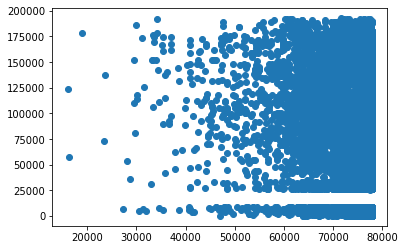

In [292]:
# Plot all movies with more than 19 ratings and the number of ratings for each movie

import matplotlib.pyplot as plt

plt.scatter(unique_movies['userId'], unique_movies['movieId'])

In [306]:
# Reshaping the dataset so that we can use KNN 
# To a sparse matrix (m x n) where m = movies and n = users

from scipy.sparse import csr_matrix
# pivot ratings into movie features
df_movie_features = rating_data_filtered.pivot(
    index='movieId',
    columns='userId',
    values='rating'
).fillna(0)

#display(df_movie_features)
# convert dataframe of movie features to scipy sparse matrix
mat_movie_features = csr_matrix(df_movie_features.values)

display(mat_movie_features)
                            
hashmap = {
    movie: i for i, movie in
    enumerate(list(movie_data.set_index('movieId').loc[df_movie_features.index].title)) # noqa
}


<6389x77851 sparse matrix of type '<class 'numpy.float64'>'
	with 7216073 stored elements in Compressed Sparse Row format>

In [283]:
from sklearn.neighbors import NearestNeighbors
model_knn = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=20, n_jobs=-1)

In [321]:
import os
import time
import gc
from fuzzywuzzy import fuzz

class KnnRecommender:
    """
    This is an item-based collaborative filtering recommender with
    KNN implmented by sklearn
    """
    def __init__(self, data, hashmap):
        self.data = data
        self.hashmap = hashmap
        self.movie_rating_thres = 0
        self.user_rating_thres = 0
        self.model = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=20, n_jobs=-1)
        
    def set_model_params(self, n_neighbors, algorithm, metric, n_jobs=None):
        """
        set model params for sklearn.neighbors.NearestNeighbors
        Parameters
        ----------
        n_neighbors: int, optional (default = 5)
        algorithm: {'auto', 'ball_tree', 'kd_tree', 'brute'}, optional
        metric: string or callable, default 'minkowski', or one of
            ['cityblock', 'cosine', 'euclidean', 'l1', 'l2', 'manhattan']
        n_jobs: int or None, optional (default=None)
        """
        if n_jobs and (n_jobs > 1 or n_jobs == -1):
            os.environ['JOBLIB_TEMP_FOLDER'] = '/tmp'
        self.model.set_params(**{
            'n_neighbors': n_neighbors,
            'algorithm': algorithm,
            'metric': metric,
            'n_jobs': n_jobs})
      
    def _fuzzy_matching(self, hashmap, fav_movie):
        """
        return the closest match via fuzzy ratio.
        If no match found, return None
        Parameters
        ----------
        hashmap: dict, map movie title name to index of the movie in data
        fav_movie: str, name of user input movie
        Return
        ------
        index of the closest match
        """
        match_tuple = []
        # get match
        for title, idx in hashmap.items():
            ratio = fuzz.ratio(title.lower(), fav_movie.lower())
            if ratio >= 60:
                match_tuple.append((title, idx, ratio))
        # sort
        match_tuple = sorted(match_tuple, key=lambda x: x[2])[::-1]
        if not match_tuple:
            print('Oops! No match is found')
        else:
            print('Found possible matches in our database: '
                  '{0}\n'.format([x[0] for x in match_tuple]))
            
            return match_tuple[0][1], match_tuple
    
        
    def _inference(self, model, data, hashmap,
                   fav_movie, n_recommendations):
        """
        return top n similar movie recommendations based on user's input movie
        Parameters
        ----------
        model: sklearn model, knn model
        data: movie-user matrix
        hashmap: dict, map movie title name to index of the movie in data
        fav_movie: str, name of user input movie
        n_recommendations: int, top n recommendations
        Return
        ------
        list of top n similar movie recommendations
        """
        # fit
        model.fit(data)
        # get input movie index
        print('You have input movie:', fav_movie)
        idx, all_similar_titles = self._fuzzy_matching(hashmap, fav_movie)
        # inference
        print('Recommendation system start to make inference')
        print('......\n')
        t0 = time.time()
        distances, indices = model.kneighbors(
            data[idx],
            n_neighbors=n_recommendations+1)
        # get list of raw idx of recommendations
        raw_recommends = \
            sorted(
                list(
                    zip(
                        indices.squeeze().tolist(),
                        distances.squeeze().tolist()
                    )
                ),
                key=lambda x: x[1]
            )[:0:-1]
        print('It took my system {:.2f}s to make inference \n\
              '.format(time.time() - t0))
        # return recommendation (movieId, distance)
        return raw_recommends, all_similar_titles

        
    def make_recommendations(self, fav_movie, n_recommendations):
        """
        make top n movie recommendations
        Parameters
        ----------
        fav_movie: str, name of user input movie
        n_recommendations: int, top n recommendations
        """

        # get data
       # movie_user_mat_sparse, hashmap = self._prep_data()
        # get recommendations
        raw_recommends, all_similar_titles = self._inference(
            self.model, self.data, self.hashmap,
            fav_movie, n_recommendations)
        # print results
        reverse_hashmap = {v: k for k, v in self.hashmap.items()}

        print('Recommendations for {}:'.format(fav_movie))
        for i, (idx, dist) in enumerate(raw_recommends):
            print('{0}: {1}, with distance '
                  'of {2}'.format(i+1, reverse_hashmap[idx], dist))


In [322]:
if __name__ == '__main__':
    # get args

    recommender = KnnRecommender(mat_movie_features, hashmap)
    # set params
   # recommender.set_filter_params(50, 50)
    recommender.set_model_params(20, 'brute', 'cosine', -1)
    # make recommendations
    recommender.make_recommendations('American Psycho', 10)

You have input movie: American Psycho
Found possible matches in our database: ['American Psycho (2000)', 'American Pop (1981)']

Recommendation system start to make inference
......

It took my system 0.19s to make inference 
              
Recommendations for American Psycho:
1: Kill Bill: Vol. 1 (2003), with distance of 0.6424555611259297
2: Unbreakable (2000), with distance of 0.6421649481380559
3: Reservoir Dogs (1992), with distance of 0.6412937688591848
4: Big Lebowski, The (1998), with distance of 0.6395335967087645
5: Shining, The (1980), with distance of 0.6365519258362742
6: The Machinist (2004), with distance of 0.6364718722298381
7: Memento (2000), with distance of 0.6364139336016303
8: Donnie Darko (2001), with distance of 0.6325628497649269
9: Requiem for a Dream (2000), with distance of 0.6296764986783426
10: 28 Days Later (2002), with distance of 0.6281691609731384


In [270]:
def look_up_id(movie_ids):
    print(len(movie_ids))
    movie_data_copy = movie_data.copy()
    movies = []
    for i in range(len(movie_ids)):
        movies.append(movie_data_copy.loc[movie_data_copy['movieId'] == movie_ids[i]])
    return movies

def look_up_name(movie_name):
    movie_data_copy = movie_data.copy()
    movie = movie_data_copy.loc[movie_data_copy['title'] == movie_name]
    return movie

In [271]:
movie_by_id = look_up_id(list([318]))
print(movie_by_id)

movie_by_name = look_up_name('Shawshank Redemption, The (1994)')
print(movie_by_name)

1
[     movieId                             title       genres
315      318  Shawshank Redemption, The (1994)  Crime|Drama]
     movieId                             title       genres
315      318  Shawshank Redemption, The (1994)  Crime|Drama


In [324]:
from sklearn.neighbors import NearestNeighbors
# testing kNN
model = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=20, n_jobs=-1)
model.fit(mat_movie_features)
distances, indices = model.kneighbors(
            mat_movie_features[1],
            n_neighbors=10)
print(indices)

[[  1 307 304 417 482 397 484 316 483 490]]


# Creating a Flask API with the model